# Análisis exploratorio de datos (EDA)

Se utilizará el conjunto de datos EchoNext (versión 1.1.0) [1].

El EDA se centrará en los tres componentes del dataset:

•	Fichero de Metadatos (EchoNext_metadata_100k.csv): La fuente de verdad para el análisis demográfico y la creación de nuestra variable objetivo.

•	Ficheros de Características Tabulares (*_tabular_features.npy): Los predictores para los modelos baseline (XGBoost, etc.).

•	Ficheros de forma de onda (*_waveforms.npy): Los predictores para el modelo principal de Deep Learning.


## Configuración del entorno

En esta sección prentendo dejar el entorno configurado para trabajar posteriormente.

Cargo las librerías a usar y  realizo configuraciones generales.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import chi2_contingency

#from google.colab import drive # Para Google Colab
# Monto Google Drive.
#drive.mount('/content/drive')

Defino variables globales.

In [2]:
# Configuro la ruta de los datos.
DRIVE_PATH = 'D:\\Desarrollo\\TFG\\' # Local
#DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/TFG/Dataset/' # Google Drive

# Defino las rutas a los ficheros
# Metadatos.
METADATA_FILE = os.path.join(DRIVE_PATH, 'echonext_metadata_100k.csv')
# Entrenamiento.
TABULAR_TRAIN_FILE = os.path.join(DRIVE_PATH, 'EchoNext_train_tabular_features.npy')
WAVEFORM_TRAIN_FILE = os.path.join(DRIVE_PATH, 'EchoNext_train_waveforms.npy')
# Prueba.
TABULAR_TEST_FILE = os.path.join(DRIVE_PATH, 'EchoNext_test_tabular_features.npy')
WAVEFORM_TEST_FILE = os.path.join(DRIVE_PATH, 'EchoNext_test_waveforms.npy')
# Val. Se usará para validación y calibración dividiendo el fichero al 50%.
TABULAR_VAL_FILE = os.path.join(DRIVE_PATH, 'EchoNext_val_tabular_features.npy')
WAVEFORM_VAL_FILE = os.path.join(DRIVE_PATH, 'EchoNext_val_waveforms.npy')

# Creo una lista de todas las variables de interés
demografic = [
    # Demográficas
    'age_at_ecg', 'race_ethnicity', 'sex'
]

context = [
    # Contexto
    'acquisition_year', 'patient_key', 'split'
]

demografic_and_context = demografic + context

ECG_Derived = [
    # Datos brutos del ECG
    'atrial_rate', 'pr_interval', 'qrs_duration', 'qt_corrected', 'ventricular_rate'
]

cols_of_interest = demografic_and_context + ECG_Derived

targets = [
    'aortic_regurgitation_value', 'aortic_stenosis_value',
    'mitral_regurgitation_value', 'pulmonary_regurgitation_value',
    'tricuspid_regurgitation_value'
]

tabular_features = ['sex', 'ventricular_rate', 'atrial_rate', 'pr_interval', 'qrs_duration', 'qt_corrected', 'age_at_ecg']

Carga de ficheros



In [3]:
# Función de carga de fichero csv
# Cargo el fichero de metadatos
def load_csv(filepath):
  try:
      df_data = pd.read_csv(filepath, low_memory=False)
      print(f"Metadatos cargados con éxito. Forma: {df_data.shape}")
      return df_data
  except FileNotFoundError:
      print(f"ERROR: No se encontró el fichero en {filepath}")
  except Exception as e:
      print(f"ERROR: Se produjo un error al cargar el fichero: {e}")

In [4]:
# Función de carga de fichero npy
# Al ser ficheros pesados, los cargaré y liberaré según se vayan necesitando.
# Para ello defino una función para cargar los ficheros npy de los predictores y ondas.
def load_npy(filepath):
  try:
      arr_data = np.load(filepath)
      print(f"Fichero npy cargado con éxito. Forma: {arr_data.shape}")
      return arr_data
  except FileNotFoundError:
      print(f"ERROR: No se encontró el fichero en {filepath}")
      return None
  except Exception as e:
      print(f"ERROR: Se produjo un error al cargar el fichero: {e}")

Funciones comunes

In [5]:
# Función para crear matrices de correlación y mostrarlas.
def plot_corr_matrix(corr_matrix, title):
    try:
        # Creo una máscara para la mitad superior
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(title)
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)  
        plt.show()

        return corr_matrix
    except Exception as e:
        print(f"Error procesando matriz de correlación: {e}")
        return None

In [6]:
# Configuro de Seaborn para los gráficos
sns.set_theme(style="whitegrid")

## Obtención de información para la secciónn 3.1.3

Tablas

In [7]:
# Cargo el fichero de metadatos
df_meta = load_csv(METADATA_FILE)

# Creo una lista de diccionarios para construir el DataFrame
summary_list = []

for col in cols_of_interest:
    if col in df_meta.columns:
        # Tipo de datos
        dtype = df_meta[col].dtype

        # Nº de valores ausentes
        n_missing = df_meta[col].isnull().sum()

        # Nº de valores únicos
        n_unique = df_meta[col].nunique()

        # Obtengo una muestra de valores
        #    Si hay pocos valores únicos (menos de 6), se muestran todos.
        #    Si hay más, se muestran 6 aleatorios.
        if n_unique > 6:
            unique_vals = df_meta[col].dropna().unique()
            sample_values = np.random.choice(unique_vals, 6, replace=False).tolist()
        else:
            sample_values = df_meta[col].dropna().unique().tolist()

        # Añado al resumen
        summary_list.append({
            'Variable': col,
            'Tipo de Datos': dtype,
            'Valores Ausentes (N)': n_missing,
            'Porcentaje Ausente (%)': round((n_missing / len(df_meta)) * 100, 2),
            'Valores Únicos (N)': n_unique,
            'Muestra de Valores': sample_values
        })
    else:
        print(f"Advertencia: La columna '{col}' no se encontró en df_meta.")

# Convierto la lista a un DataFrame de Pandas
df_summary = pd.DataFrame(summary_list)

df_demografic_and_context = df_summary[df_summary['Variable'].isin(demografic_and_context)]
df_ECG_Derived = df_summary[df_summary['Variable'].isin(ECG_Derived)]

# Muestro las tablas en el notebook
print("Tabla resumen de las variables demográficas y de contexto del fichero de metadatos:")
display(df_demografic_and_context)

# Muestro las tablas en el notebook
print("Tabla resumen de las variables en bruto del ECG:")
display(df_ECG_Derived)

Metadatos cargados con éxito. Forma: (100000, 39)
Tabla resumen de las variables demográficas y de contexto del fichero de metadatos:


,Variable,Tipo de Datos,Valores Ausentes (N),Porcentaje Ausente (%),Valores Únicos (N),Muestra de Valores
0,age_at_ecg,int64,0,0.0,73,"[53, 29, 18, 48, 77, 79]"
1,race_ethnicity,object,0,0.0,6,"[other, black, white, hispanic, asian, unknown]"
2,sex,object,0,0.0,2,"[male, female]"
3,acquisition_year,int64,0,0.0,15,"[2017, 2020, 2008, 2016, 2009, 2013]"
4,patient_key,int64,0,0.0,36286,"[2812626971, 3352331980, 504463402, 9124310474..."
5,split,object,0,0.0,4,"[train, val, test, no_split]"


Tabla resumen de las variables en bruto del ECG:


,Variable,Tipo de Datos,Valores Ausentes (N),Porcentaje Ausente (%),Valores Únicos (N),Muestra de Valores
6,atrial_rate,float64,613,0.61,318,"[83.0, 316.0, 351.0, 117.0, 175.0, 266.0]"
7,pr_interval,float64,10369,10.37,205,"[326.0, 52.0, 290.0, 424.0, 212.0, 362.0]"
8,qrs_duration,float64,0,0.00,125,"[80.0, 82.0, 140.0, 46.0, 87.0, 188.0]"
9,qt_corrected,float64,1,0.00,481,"[667.0, 355.0, 431.0, 452.0, 694.0, 654.0]"
10,ventricular_rate,float64,0,0.00,190,"[152.0, 112.0, 60.0, 69.0, 118.0, 179.0]"


In [11]:
print(df_meta['split'].value_counts())

split
train       72475
no_split    17457
test         5442
val          4626
Name: count, dtype: int64


Figuras

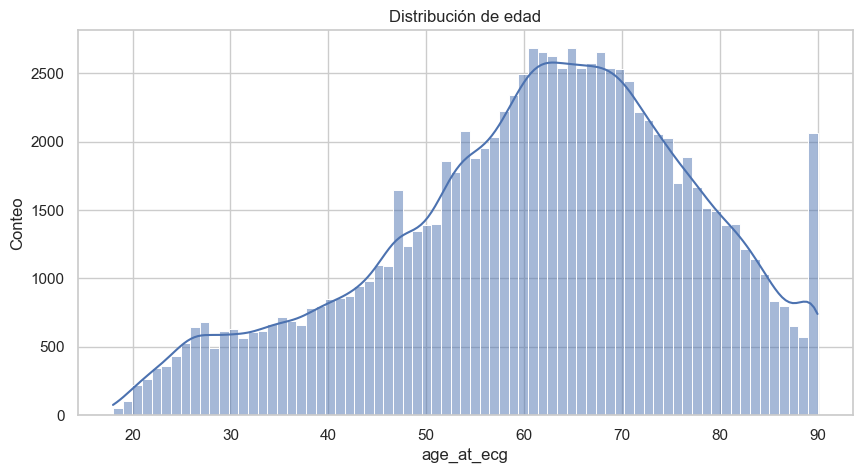

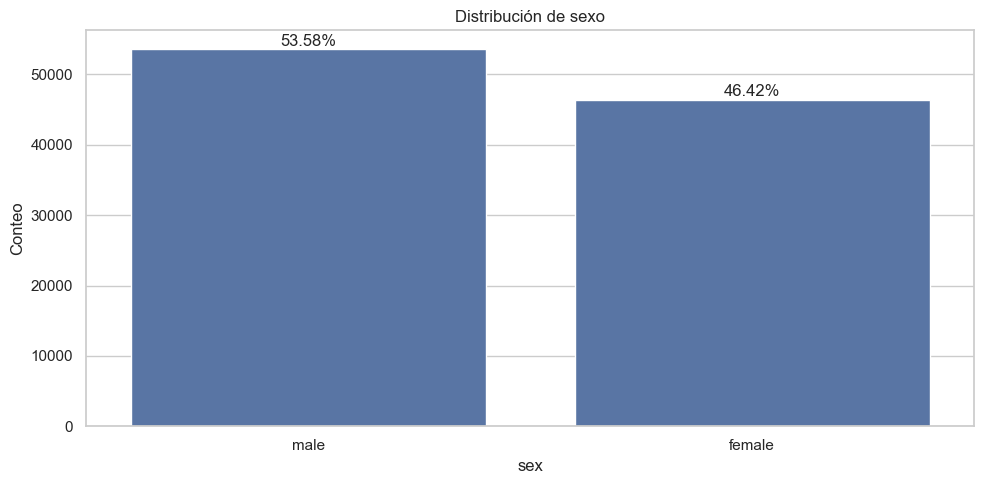

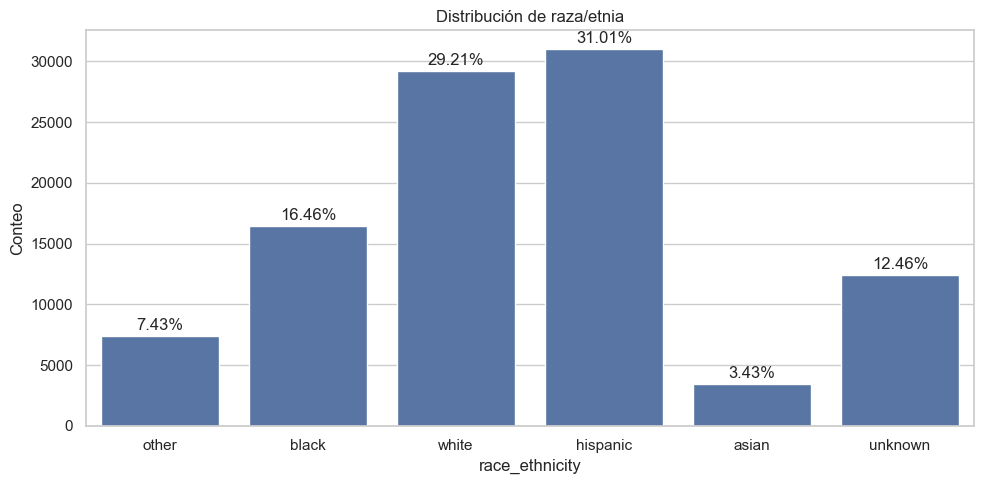

In [8]:
# Gráfico (Figura a)
plt.figure(figsize=(10, 5))
sns.histplot(df_meta['age_at_ecg'], bins=73, kde=True).set_title('Distribución de edad')
plt.ylabel('Conteo')
plt.show()

print("")

# Gráficos (Figura b)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.countplot(data=df_meta, x='sex', ax=axes)
ax.set_title('Distribución de sexo')
ax.set_ylabel('Conteo')
total = len(df_meta)
# Añado el % sobre cada barra
for p in ax.patches:
    height = p.get_height()
    porcentaje = 100 * height / total
    ax.text(
        p.get_x() + p.get_width() / 2,  # Centrado
        height + total * 0.005,         # Por encima de la barra
        f'{porcentaje:.2f}%',           # Con 2 decimales
        ha='center'
    )
# Muestro la figura
plt.tight_layout()
plt.show()

print("")

# Gráficos (Figura c)
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.countplot(data=df_meta, x='race_ethnicity', ax=axes)
ax.set_title('Distribución de raza/etnia')
ax.set_ylabel('Conteo')
total = len(df_meta)
# Añado el % sobre cada barra
for p in ax.patches:
    height = p.get_height()
    porcentaje = 100 * height / total
    ax.text(
        p.get_x() + p.get_width() / 2,  # Centrado
        height + total * 0.005,         # Por encima de la barra
        f'{porcentaje:.2f}%',           # Con 2 decimales
        ha='center'
    )
# Muestro la figura
plt.tight_layout()
plt.show()

print("")

## Obtención de información para la sección 3.1.4

Comienzo con el estudio del fichero tabular de predictores.
Para ello voy a hacer un estudio de correlación

Fichero npy cargado con éxito. Forma: (72475, 7)


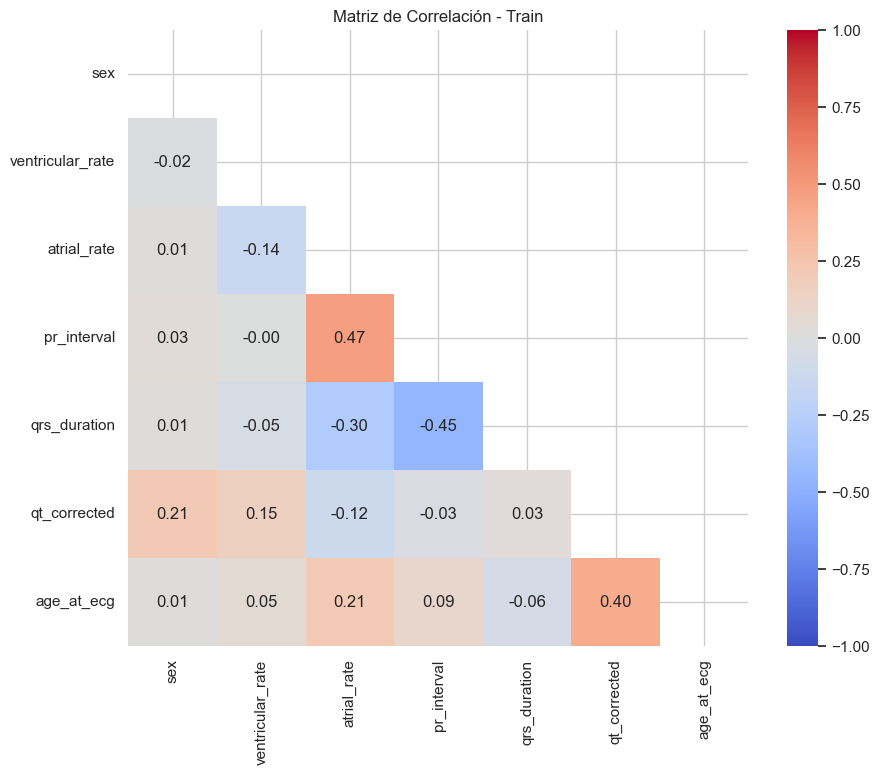

Fichero npy cargado con éxito. Forma: (4626, 7)


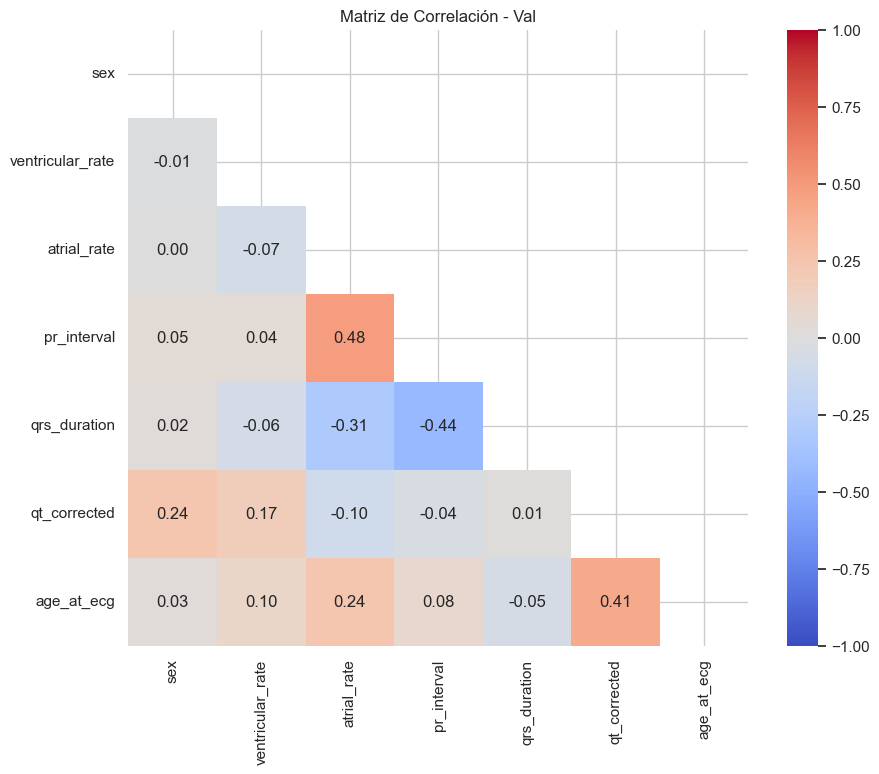

Fichero npy cargado con éxito. Forma: (5442, 7)


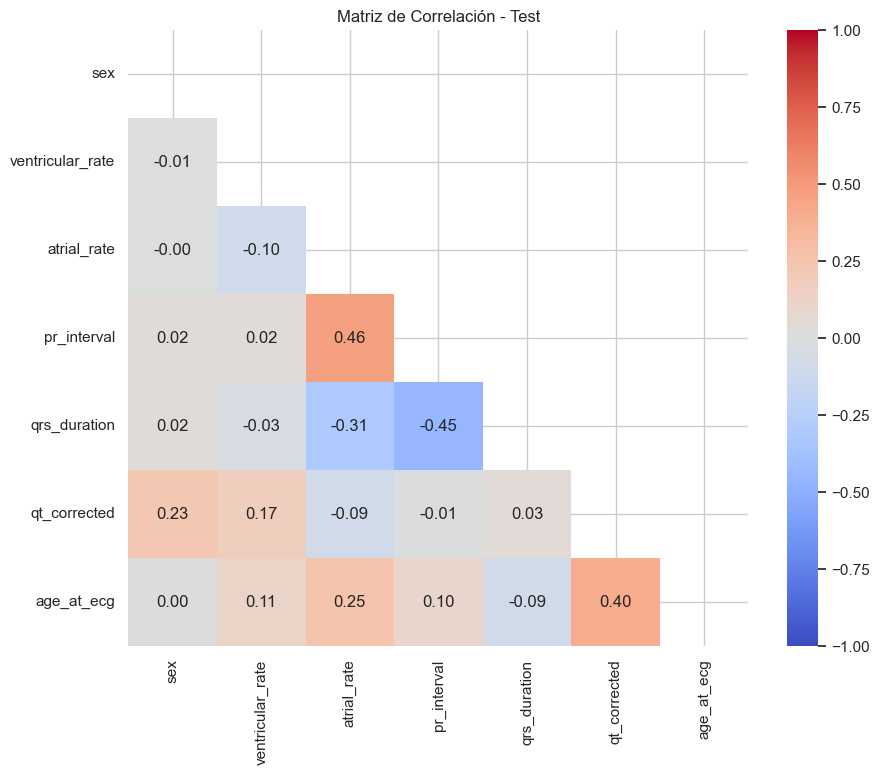

In [9]:
# Muestro las matrices de correlacion de los ficheros tabulares por split.
arr_tabular_features = load_npy(TABULAR_TRAIN_FILE)
df_tabular = pd.DataFrame(arr_tabular_features, columns=tabular_features)
corr_matrix = df_tabular.corr()
corr_train = plot_corr_matrix(corr_matrix, "Matriz de Correlación - Train")
del arr_tabular_features, df_tabular # Libero la memoria

arr_tabular_features= load_npy(TABULAR_VAL_FILE)
df_tabular = pd.DataFrame(arr_tabular_features, columns=tabular_features)
corr_matrix = df_tabular.corr()
corr_val = plot_corr_matrix(corr_matrix, "Matriz de Correlación - Val")
del arr_tabular_features, df_tabular # Libero la memoria

arr_tabular_features = load_npy(TABULAR_TEST_FILE)
df_tabular = pd.DataFrame(arr_tabular_features, columns=tabular_features)
corr_matrix = df_tabular.corr()
corr_test = plot_corr_matrix(corr_matrix, "Matriz de Correlación - Test")
del arr_tabular_features, df_tabular # Libero la memoria

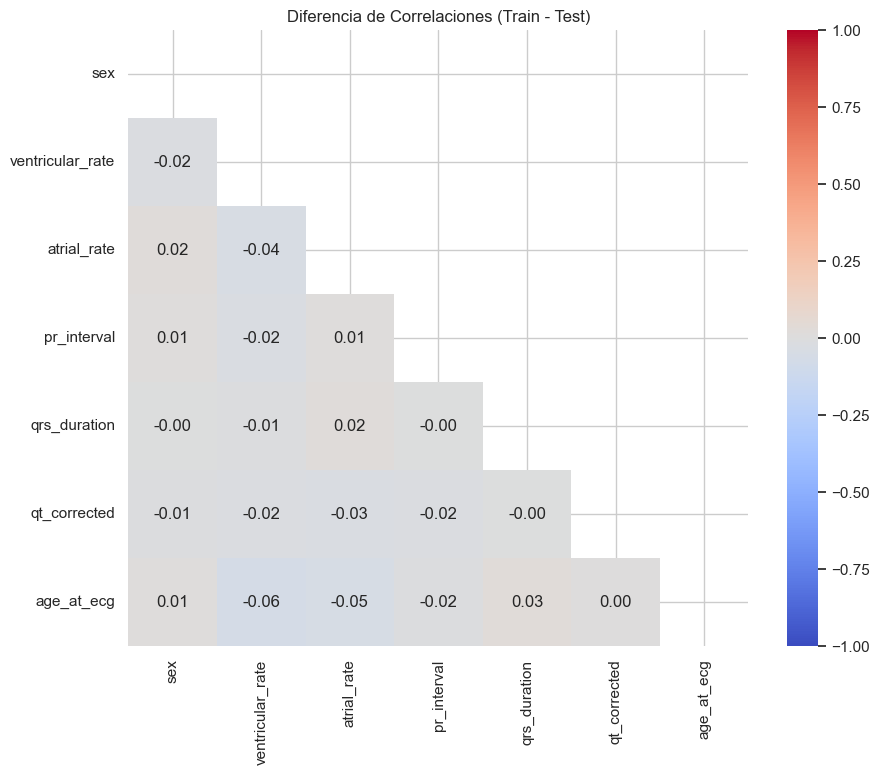

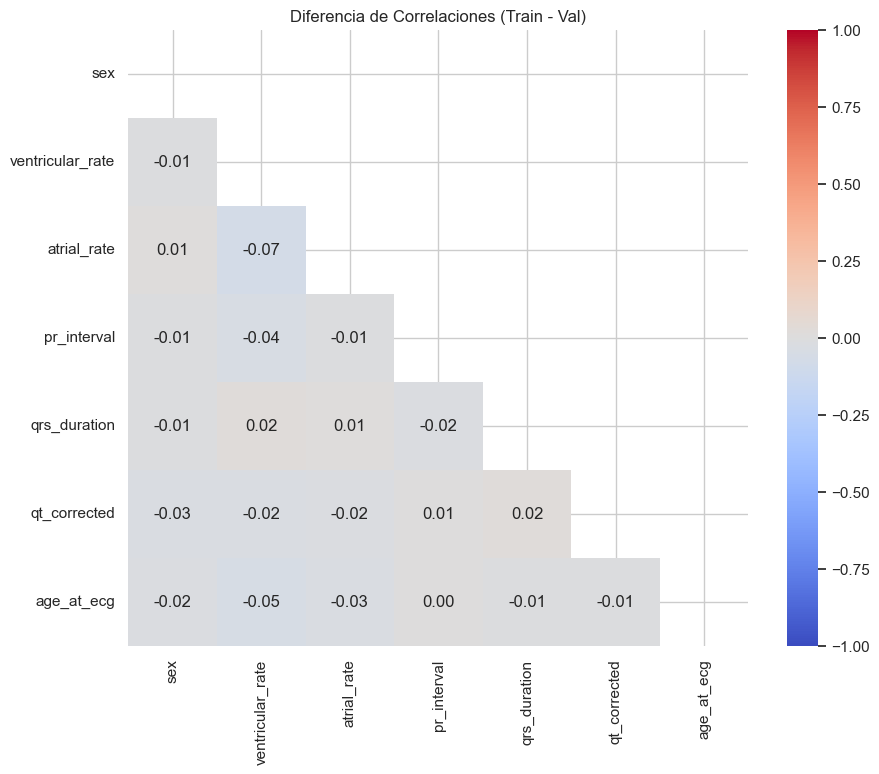

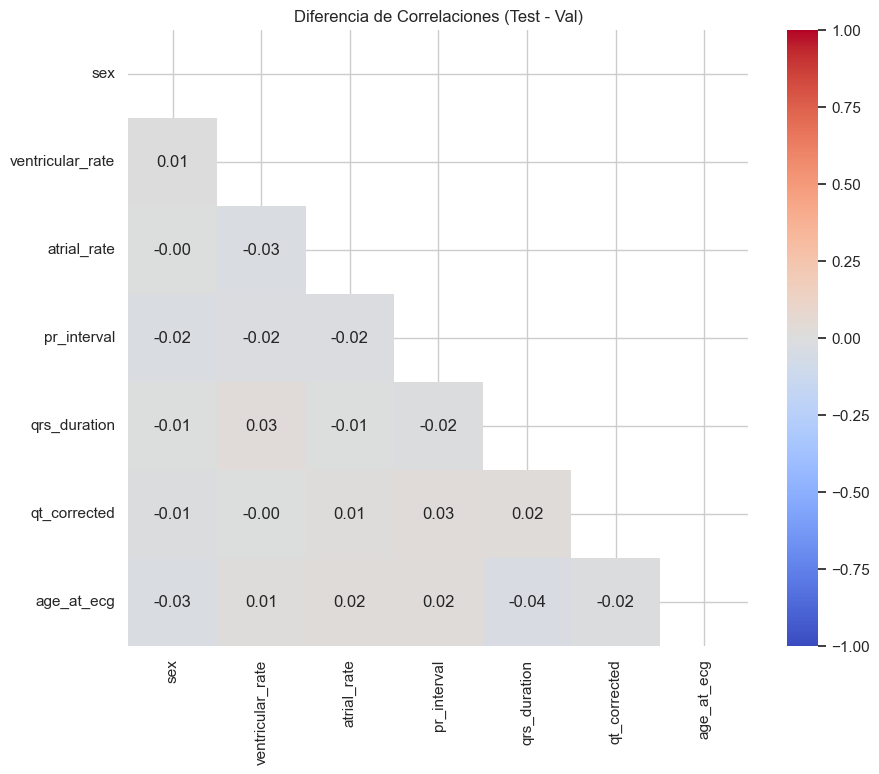

In [10]:
# Genero unas matrices de diferencia de correlación
diff_corr_train_test = corr_train - corr_test
diff = plot_corr_matrix(diff_corr_train_test, "Diferencia de Correlaciones (Train - Test)")

diff_corr_train_val = corr_train - corr_val
diff = plot_corr_matrix(diff_corr_train_val, "Diferencia de Correlaciones (Train - Val)")

diff_corr_test_val = corr_test - corr_val
diff = plot_corr_matrix(diff_corr_test_val, "Diferencia de Correlaciones (Test - Val)")

## Obtención de información para la sección 3.1.5

Comienzo con el estudio del fichero de onda.

Fichero npy cargado con éxito. Forma: (72475, 1, 2500, 12)
(a) Paciente 'Ninguna'


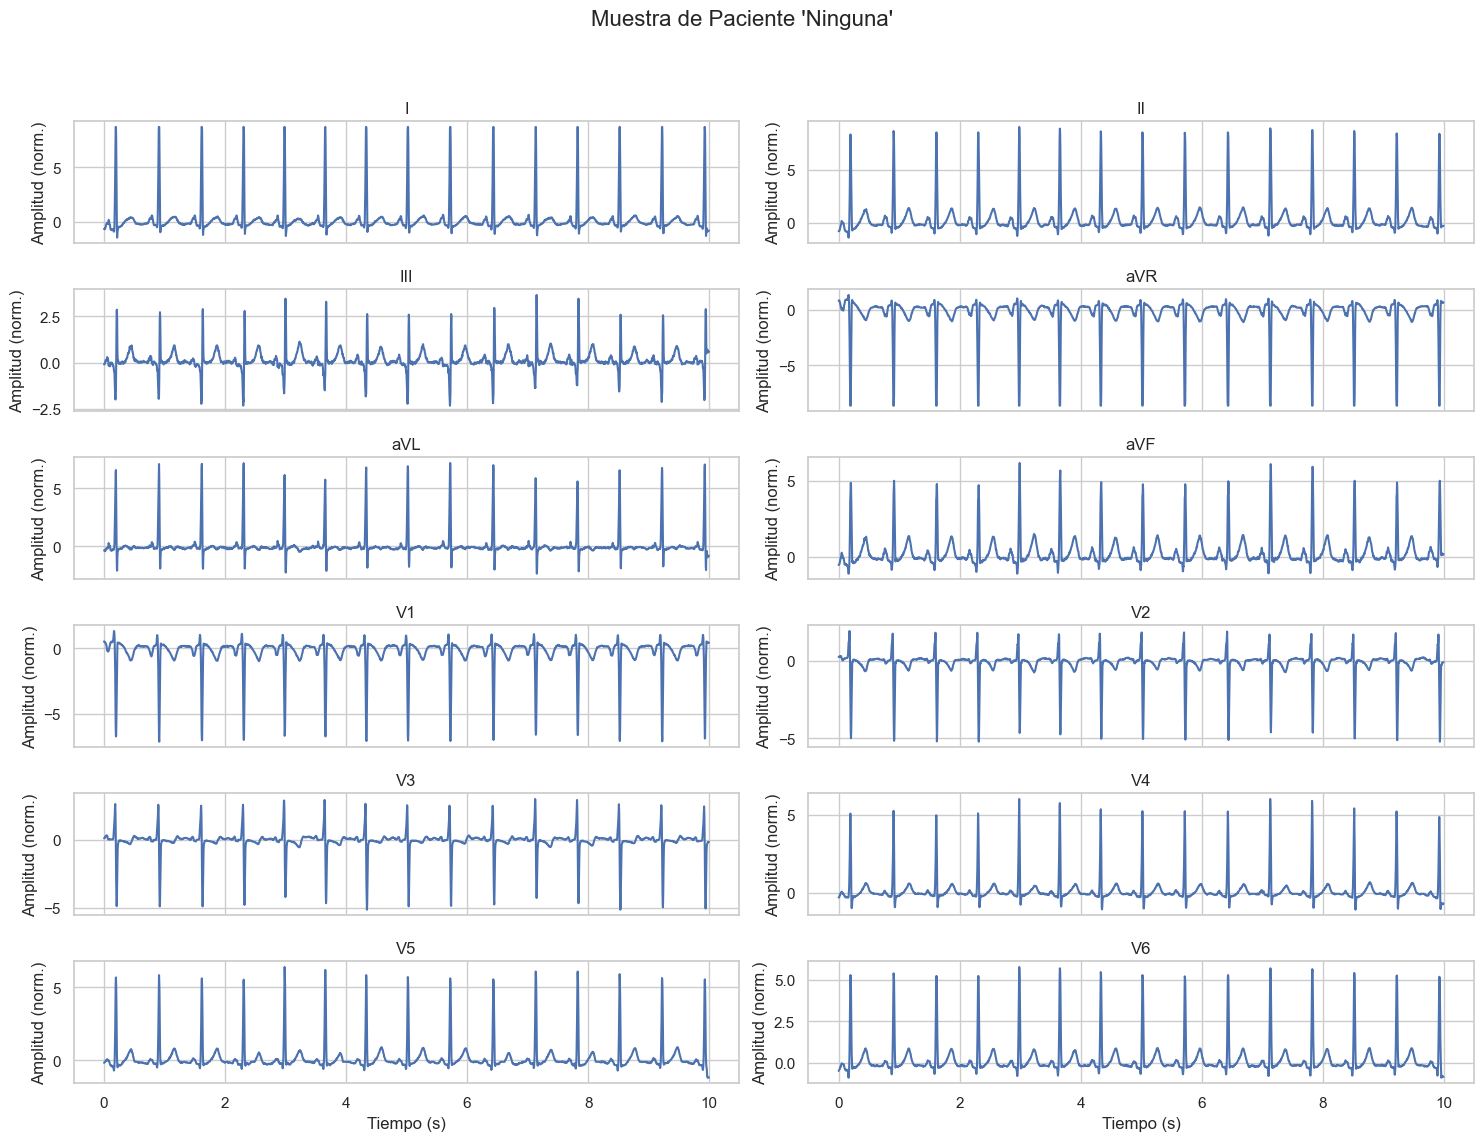

(b) Paciente 'Insuficiencia'


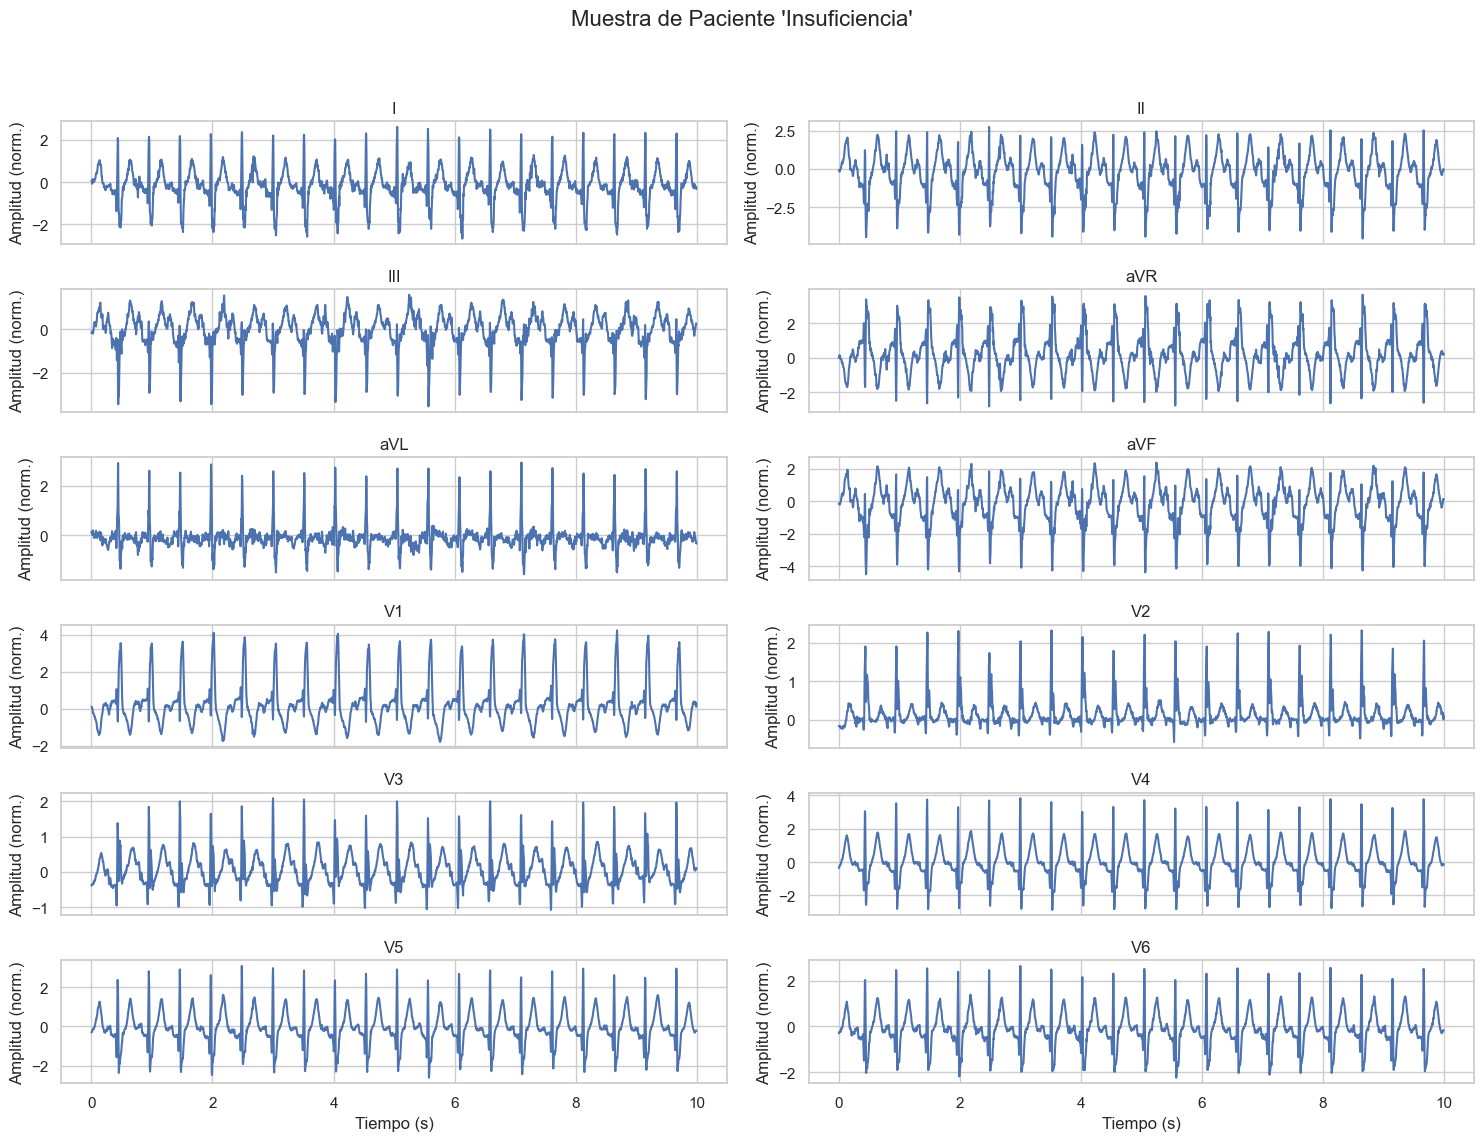

(c) Paciente 'Estenosis'


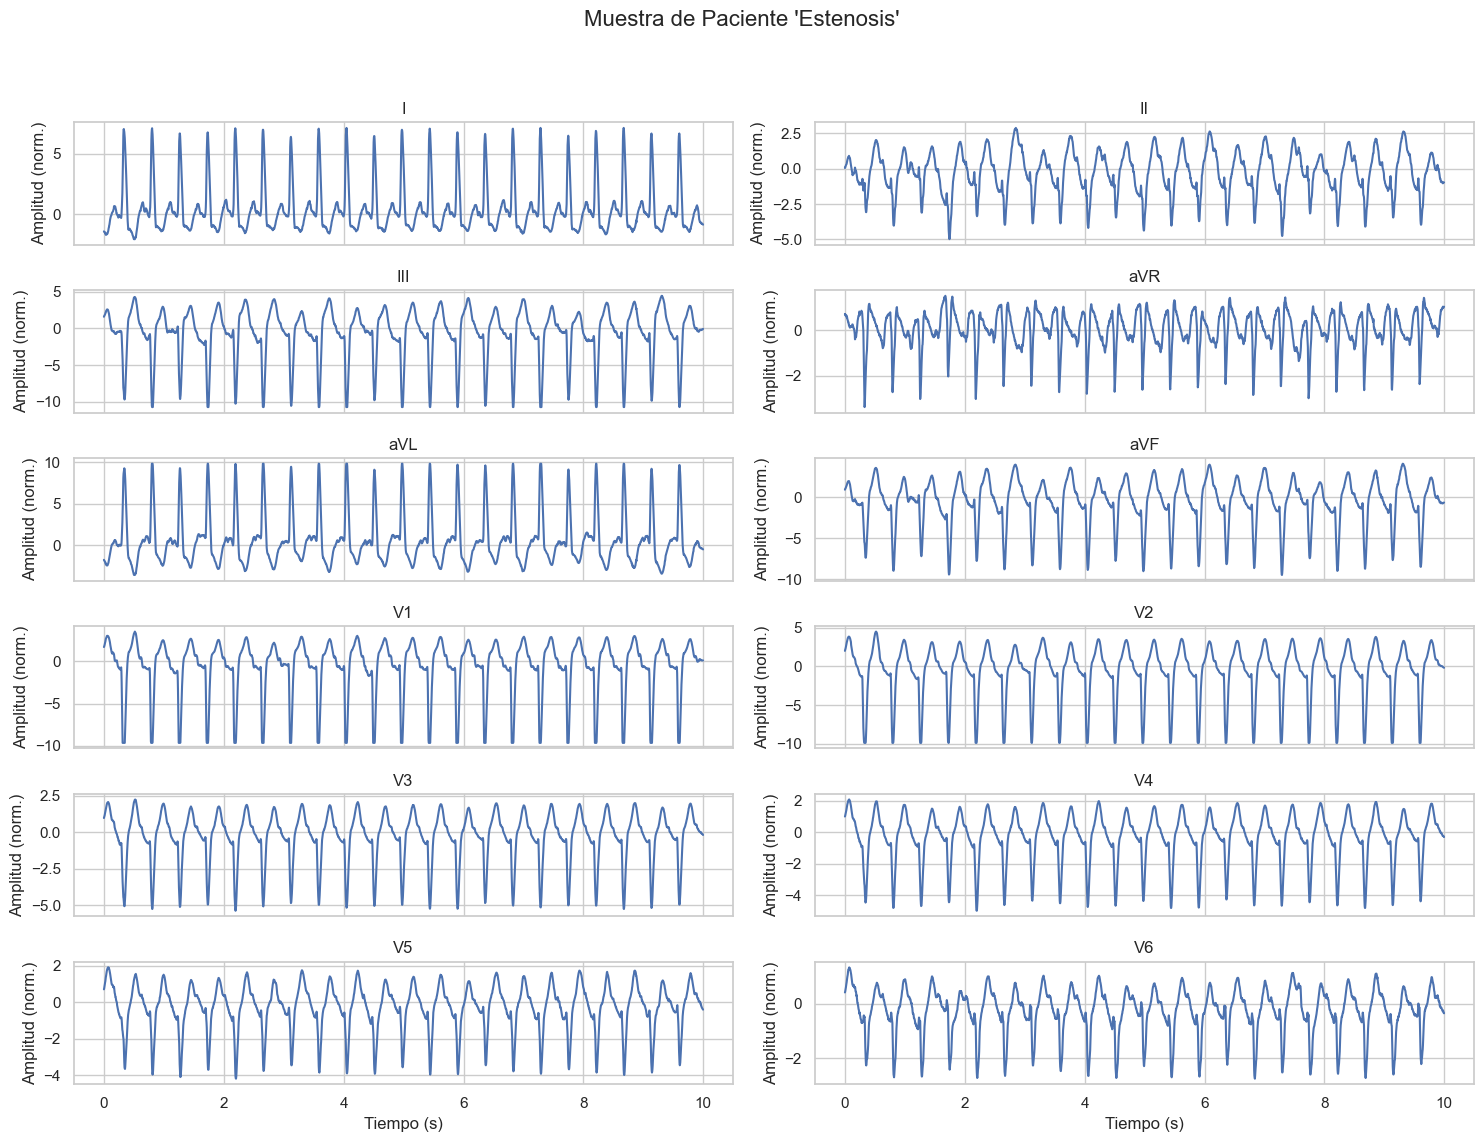

(d) Paciente 'Ambas'


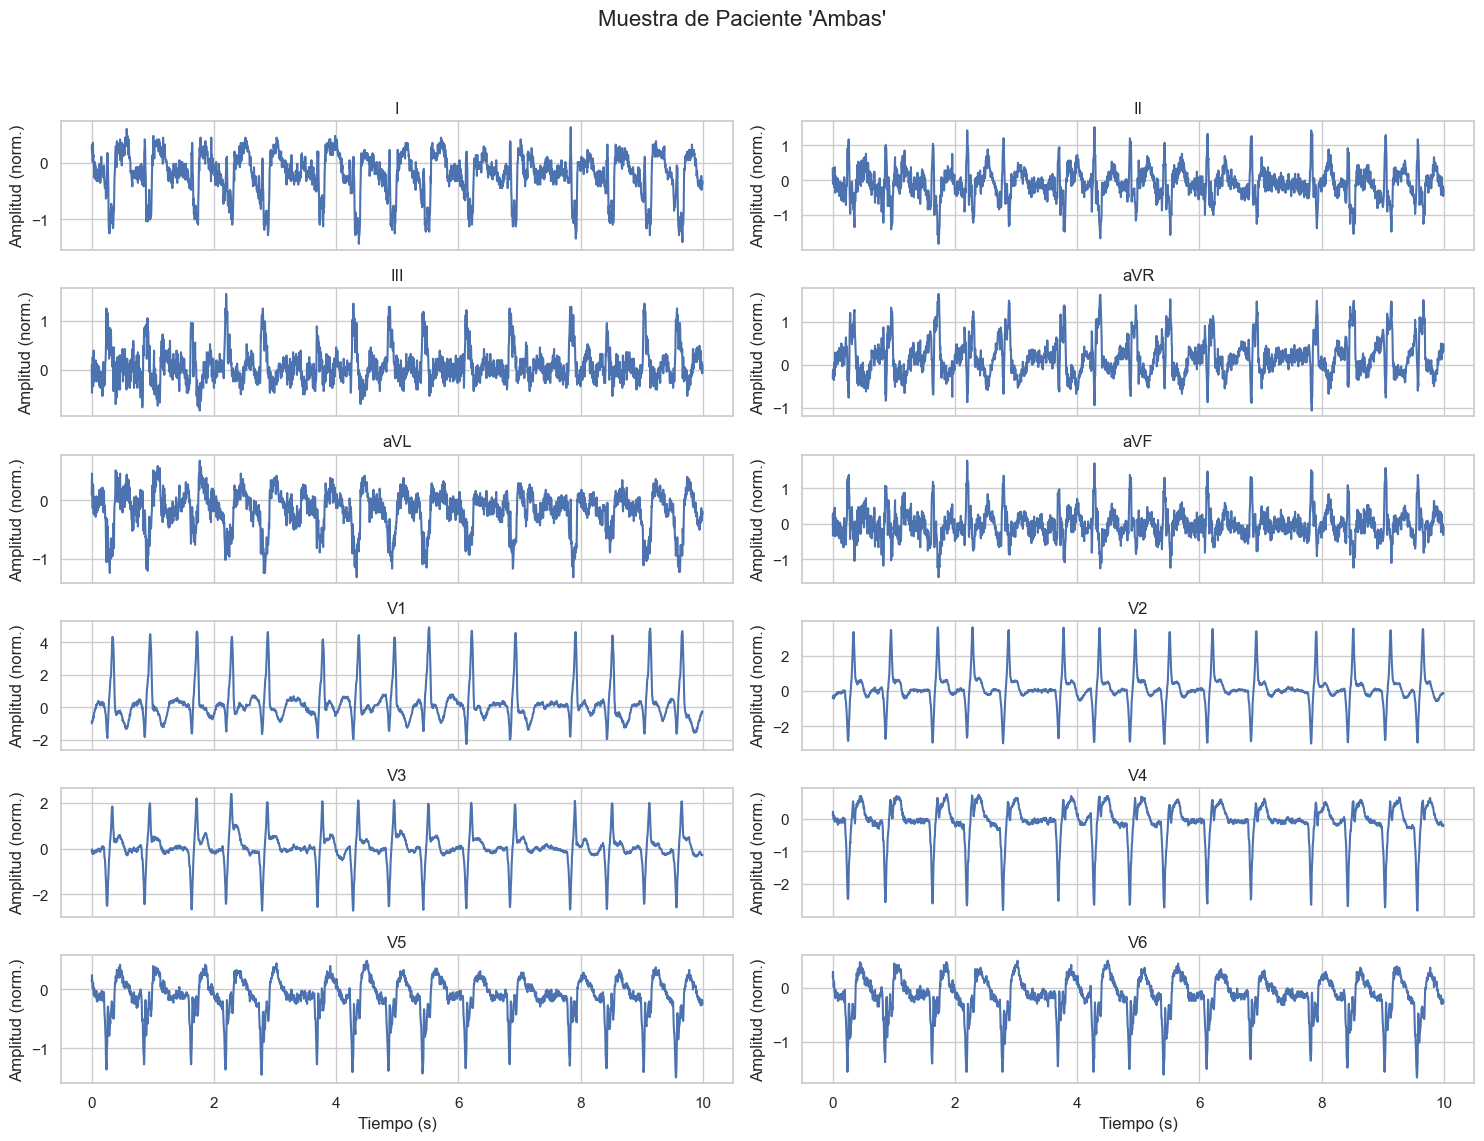

In [11]:
# Cargo el fichero de onda.
# En este caso el de validación, por ser el más pequeño.

arr_waveforms = load_npy(WAVEFORM_TRAIN_FILE)

# Preparo las figuras de los ECG para las diversas cardiopatías del trabajo.
# Creo una función para graficar un ECG de 12 derivaciones
def plot_ecg_12_leads(ecg_data, title="ECG 12 Derivaciones"):
    ecg_data = ecg_data.squeeze()
    fig, axes = plt.subplots(6, 2, figsize=(15, 12))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    time = np.arange(ecg_data.shape[0]) / SAMPLE_RATE
    for i in range(12):
        axes[i].plot(time, ecg_data[:, i])
        axes[i].set_title(LEADS[i])
        axes[i].set_ylabel('Amplitud (norm.)')
        if i >= 10: axes[i].set_xlabel('Tiempo (s)')
        else: axes[i].set_xticklabels([])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Obtengo los índices de cada partición original
val_indices_original = df_meta[df_meta['split'] == 'val'].index

# Defino la información que contiene el fichero del ECG
LEADS = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'] # Derivaciones
SAMPLE_RATE = 250

# Uso el df_meta para buscar los índices de los ECG a mostrar.
# Y los val_indices_original para mapear
df_meta_val = df_meta[df_meta['split'] == 'val']

# Mapeo: {índice_df (100k): índice_array}
val_idx_map = {idx: i for i, idx in enumerate(val_indices_original)}

try:
    # Busco índices del DF limpio
    idx_ninguna = df_meta_val[(
                              (df_meta_val['aortic_stenosis_value'] == 'none') &
                              (df_meta_val['aortic_regurgitation_value'] == 'none') &
                              (df_meta_val['mitral_regurgitation_value'] == 'none') &
                              (df_meta_val['tricuspid_regurgitation_value'] == 'none') &
                              (df_meta_val['pulmonary_regurgitation_value'] == 'none')
                            )].index[0]
    idx_insuf = df_meta_val[(
                              (df_meta_val['aortic_stenosis_value'] == 'none') &
                              (
                                (df_meta_val['aortic_regurgitation_value'] != 'none') |
                                (df_meta_val['mitral_regurgitation_value'] != 'none') |
                                (df_meta_val['tricuspid_regurgitation_value'] != 'none') |
                                (df_meta_val['pulmonary_regurgitation_value'] != 'none')
                              )
                            )].index[0]
    idx_esten = df_meta_val[(
                              (df_meta_val['aortic_stenosis_value'] != 'none') &
                              (df_meta_val['aortic_regurgitation_value'] == 'none') &
                              (df_meta_val['mitral_regurgitation_value'] == 'none') &
                              (df_meta_val['tricuspid_regurgitation_value'] == 'none') &
                              (df_meta_val['pulmonary_regurgitation_value'] == 'none')
                            )].index[0]
    idx_ambas = df_meta_val[(
                              (df_meta_val['aortic_stenosis_value'] != 'none') &
                              (
                                (df_meta_val['aortic_regurgitation_value'] != 'none') |
                                (df_meta_val['mitral_regurgitation_value'] != 'none') |
                                (df_meta_val['tricuspid_regurgitation_value'] != 'none') |
                                (df_meta_val['pulmonary_regurgitation_value'] != 'none')
                              )
                            )].index[0]

    # Mapeo y extraigo del array
    ecg_ninguna = arr_waveforms[val_idx_map[idx_ninguna]]
    ecg_insuf = arr_waveforms[val_idx_map[idx_insuf]]
    ecg_esten = arr_waveforms[val_idx_map[idx_esten]]
    ecg_ambas = arr_waveforms[val_idx_map[idx_ambas]]

    # Creo las figuras
    print("(a) Paciente 'Ninguna'")
    plot_ecg_12_leads(ecg_ninguna, title="Muestra de Paciente 'Ninguna'")
    print("(b) Paciente 'Insuficiencia'")
    plot_ecg_12_leads(ecg_insuf, title="Muestra de Paciente 'Insuficiencia'")
    print("(c) Paciente 'Estenosis'")
    plot_ecg_12_leads(ecg_esten, title="Muestra de Paciente 'Estenosis'")
    print("(d) Paciente 'Ambas'")
    plot_ecg_12_leads(ecg_ambas, title="Muestra de Paciente 'Ambas'")

    del arr_waveforms # Libero la memoria

except NameError:
    print("\n'arr_waveforms' no se cargó.")
except IndexError:
    print(f"\nNo se pudo encontrar un ejemplo para cada clase en el set de 'val'.")

## Creación de la variable objetivo. Sección 3.2

In [12]:
# Creo una lista de diccionarios para construir el DataFrame
summary_list = []

for col in targets:
    if col in df_meta.columns:
        # Tipo de datos
        dtype = df_meta[col].dtype

        # Nº de valores ausentes
        n_missing = df_meta[col].isnull().sum()

        # Nº de valores únicos
        n_unique = df_meta[col].nunique()

        # Obtengo una muestra de valores
        #    Si hay pocos valores únicos (menos de 6), se muestran todos.
        #    Si hay más, se muestran 6 aleatorios.
        if n_unique > 6:
            unique_vals = df_meta[col].dropna().unique()
            sample_values = np.random.choice(unique_vals, 6, replace=False).tolist()
        else:
            sample_values = df_meta[col].dropna().unique().tolist()

        # Añado al resumen
        summary_list.append({
            'Variable': col,
            'Tipo de Datos': dtype,
            'Valores Ausentes (N)': n_missing,
            'Porcentaje Ausente (%)': round((n_missing / len(df_meta)) * 100, 2),
            'Valores Únicos (N)': n_unique,
            'Muestra de Valores': sample_values
        })
    else:
        print(f"Advertencia: La columna '{col}' no se encontró en df_meta.")

# Convierto la lista a un DataFrame de Pandas
df_summary = pd.DataFrame(summary_list)

df_targets = df_summary[df_summary['Variable'].isin(targets)]

# Muestro las tablas en el notebook
print("Tabla resumen de las variables targets del fichero de metadatos:")
display(df_targets)


Tabla resumen de las variables targets del fichero de metadatos:


,Variable,Tipo de Datos,Valores Ausentes (N),Porcentaje Ausente (%),Valores Únicos (N),Muestra de Valores
0,aortic_regurgitation_value,object,9003,9.00,5,"[none, mild, severe, presumed none, moderate]"
1,aortic_stenosis_value,object,9003,9.00,5,"[none, presumed none, mild, severe, moderate]"
2,mitral_regurgitation_value,object,9000,9.00,5,"[mild, none, severe, moderate, presumed none]"
3,pulmonary_regurgitation_value,object,8944,8.94,5,"[presumed none, none, mild, moderate, severe]"
4,tricuspid_regurgitation_value,object,9036,9.04,5,"[none, mild, moderate, severe, presumed none]"


Al no poder crear la variable target final con si no se cononce el valor de alguna de las variables objetivo definidas, se eliminan las filas con valores ausentes.

In [13]:
# Elimino valores ausentes en las columnas de target.
df_meta_clean = df_meta.dropna(subset=targets).copy()

# Muestro cuantos registros quedan.
print(f"Registros inciales: {len(df_meta)}.")
print(f"Registros tras la limpieza: {len(df_meta_clean)}.")

Registros inciales: 100000.
Registros tras la limpieza: 90861.


Procedo a preparar la variable target.

In [14]:
# Preparo la variable objetivo
df_meta_clean['tiene_estenosis'] = df_meta_clean['aortic_stenosis_value'] != 'none'
df_meta_clean['tiene_insuficiencia'] = (
    (df_meta_clean['aortic_regurgitation_value'] != 'none') |
    (df_meta_clean['mitral_regurgitation_value'] != 'none') |
    (df_meta_clean['tricuspid_regurgitation_value'] != 'none') |
    (df_meta_clean['pulmonary_regurgitation_value'] != 'none')
)

def crear_cardiopatia(row):
    if row['tiene_estenosis'] and row['tiene_insuficiencia']:
        return 'Ambas'
    elif row['tiene_estenosis']:
        return 'Estenosis'
    elif row['tiene_insuficiencia']:
        return 'Insuficiencia'
    else:
        return 'Ninguna'

df_meta_clean['cardiopatia'] = df_meta_clean.apply(crear_cardiopatia, axis=1)

print("Variable cardiopatia creada en 'df_meta_clean'.")

Variable cardiopatia creada en 'df_meta_clean'.


--- Tabla: Distribución de la variable cardiopatia con los datos Limpios) ---
               Conteo (N)  Porcentaje (%)
cardiopatia                              
Insuficiencia       59316           65.28
Ninguna             18081           19.90
Ambas               11833           13.02
Estenosis            1631            1.80


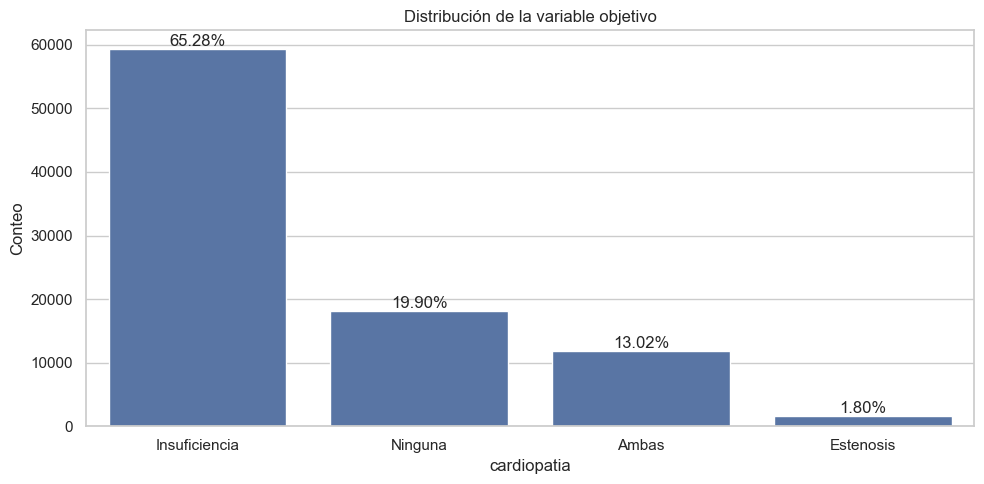

In [17]:
# --- Genero Tabla y Figura ---
target_counts = df_meta_clean['cardiopatia'].value_counts()
target_perc = (df_meta_clean['cardiopatia'].value_counts(normalize=True) * 100).round(2)

# Tabla
print("--- Tabla: Distribución de la variable cardiopatia con los datos Limpios) ---")
tabla_cardiopatia = pd.DataFrame({'Conteo (N)': target_counts, 'Porcentaje (%)': target_perc})
print(tabla_cardiopatia)

# Figura
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.countplot(data=df_meta_clean, x='cardiopatia', ax=axes)
ax.set_title('Distribución de la variable objetivo')
ax.set_ylabel('Conteo')
total = len(df_meta_clean)
# Añado el % sobre cada barra
for p in ax.patches:
    height = p.get_height()
    porcentaje = 100 * height / total
    ax.text(
        p.get_x() + p.get_width() / 2,  # Centrado
        height + total * 0.005,         # Por encima de la barra
        f'{porcentaje:.2f}%',           # Con 2 decimales
        ha='center'
    )
# Muestro la figura
plt.tight_layout()
plt.show()

## Obtención de información para la sección 3.3

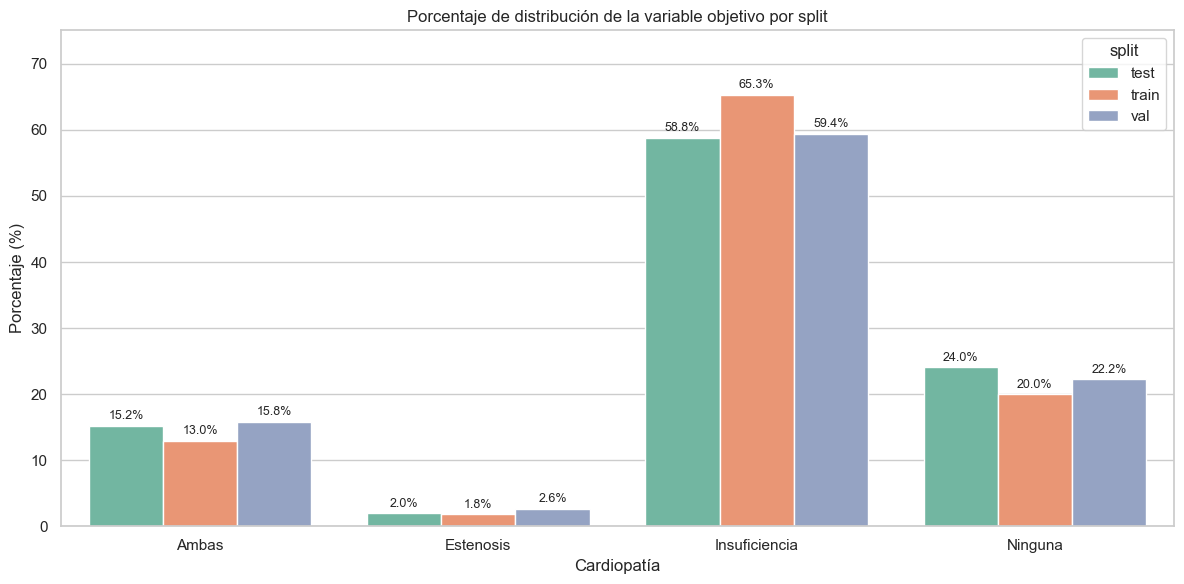

In [16]:
# Preparo los conteos para evaluar las cardiopatías por split
df_counts = df_meta_clean[df_meta_clean['split'] != 'no_split'].groupby(['split', 'cardiopatia']).size().reset_index(name='count')
df_counts['percent'] = df_counts.groupby('split')['count'].transform(lambda x: 100 * x / x.sum())

# Creo el gráfico
plt.figure(figsize=(12,6))
ax = sns.barplot(data=df_counts, x='cardiopatia', y='percent', hue='split', palette='Set2')

# Añado el porcentaje sobre cada barra
for p, (_, row) in zip(ax.patches, df_counts.iterrows()):
    ax.text(
        x=p.get_x() + p.get_width() / 2,
        y=p.get_height() + 1,
        s=f"{row['percent']:.1f}%",
        ha='center',
        fontsize=9
    )

ax.set_title('Porcentaje de distribución de la variable objetivo por split')
ax.set_ylabel('Porcentaje (%)')
ax.set_xlabel('Cardiopatía')
ax.set_ylim(0, df_counts['percent'].max()*1.15)
plt.legend(title='split')
plt.tight_layout()
plt.show()

In [17]:
print("--- Prueba Chi-cuadrado de Independencia ---")
print("H_0: La 'cardiopatia' es INDEPENDIENTE del 'split'.")
print("H_1: La 'cardiopatia' DEPENDE del 'split'.\n")

# Filtro para obtener solamente los split 'train', 'validation' y 'test'
df_analysis = df_meta_clean[df_meta_clean['split'].isin(['train', 'val', 'test'])]


# Creo la Tabla de Contingencia
contingency_table = pd.crosstab(df_analysis['cardiopatia'], df_analysis['split'])

print("Tabla de Contingencia (Observada):")
display(contingency_table)

# Ejecuto la prueba Chi-cuadrado
chi2_stat, p_value, dof, expected_freqs = chi2_contingency(contingency_table)

print(f"Resultados de la Prueba:")
print(f" - Estadístico Chi-cuadrado: {chi2_stat:.4f}")
print(f" - Grados de libertad (dof): {dof}")
print(f" - p-valor: {p_value}")

# Interpreto el resultado
alpha = 0.05
if p_value < alpha:
    print(f"\nConclusión (p < {alpha}): Se RECHAZA la hipótesis nula (H_0).")
    print("Las distribuciones de 'cardiopatia' SON estadísticamente DIFERENTES entre los splits.")
    print("-> Se confirma el Target Distribution Shift.")
else:
    print(f"\nConclusión (p >= {alpha}): NO se puede rechazar la hipótesis nula (H_0).")
    print("Las distribuciones SON estadísticamente similares.")

--- Prueba Chi-cuadrado de Independencia ---
H_0: La 'cardiopatia' es INDEPENDIENTE del 'split'.
H_1: La 'cardiopatia' DEPENDE del 'split'.

Tabla de Contingencia (Observada):


split,test,train,val
cardiopatia,,,
Ambas,731,8538,648
Estenosis,94,1185,108
Insuficiencia,2833,43006,2438
Ninguna,1157,13149,912


Resultados de la Prueba:
 - Estadístico Chi-cuadrado: 143.0413
 - Grados de libertad (dof): 6
 - p-valor: 2.285326123156715e-28

Conclusión (p < 0.05): Se RECHAZA la hipótesis nula (H_0).
Las distribuciones de 'cardiopatia' SON estadísticamente DIFERENTES entre los splits.
-> Se confirma el Target Distribution Shift.


# Bibliografía

[1] Elias, P., & Finer, J. (2025). EchoNext: A Dataset for Detecting Echocardiogram-Confirmed Structural Heart Disease from ECGs (version 1.1.0). PhysioNet. RRID:SCR_007345. https://doi.org/10.13026/3ykd-bf14